In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

from PIL import Image
from tqdm.auto import tqdm

from sklearn.metrics import f1_score

In [3]:
TRAIN_PATH = '/opt/ml/input/data/train/'
TRAIN_IMAGE_PATH = '/opt/ml/input/data/train/processed_train_images/'

In [4]:
train_df = pd.read_csv(os.path.join(TRAIN_PATH, 'preprocessed_train.csv'))
train_df

,Unnamed: 0,id,gender,mask,age,age_3,age_11,label,path
0,0,004394,0,1,53,1,5,7,/opt/ml/input/data/train/processed_train_image...
1,1,000545,1,2,58,1,5,16,/opt/ml/input/data/train/processed_train_image...
2,2,006155,0,0,20,0,2,0,/opt/ml/input/data/train/processed_train_image...
3,3,006236,0,1,20,0,2,6,/opt/ml/input/data/train/processed_train_image...
4,4,003713,1,0,55,1,5,4,/opt/ml/input/data/train/processed_train_image...
...,...,...,...,...,...,...,...,...,...
18888,18888,003314,1,0,20,0,2,3,/opt/ml/input/data/train/processed_train_image...
18889,18889,006955,0,0,19,0,1,0,/opt/ml/input/data/train/processed_train_image...
18890,18890,003555,1,0,48,1,4,4,/opt/ml/input/data/train/processed_train_image...
18891,18891,003469,1,2,55,1,5,16,/opt/ml/input/data/train/processed_train_image...


In [5]:
class maskDataset(Dataset):
    def __init__(self, train_df, transform, train=True):
        self.train = train
        self.transform = transform

        if self.train == True:
            self.paths = train_df['path']
            self.labels = train_df['label']
        else:
            self.paths = train_df
        

    def __getitem__(self, index):
        if self.train:
            image = Image.open(self.paths.iloc[index])
            label = self.labels.iloc[index]
        else:
            image = Image.open(self.paths[index])

        if self.transform:
            image = self.transform(image)

        if self.train:
            return image, torch.tensor(label)
        else:
            return image

    def __len__(self):
        return len(self.paths)

In [6]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    #Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

In [7]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size=0.2, shuffle=True, stratify=train_df['label'], random_state=34)

In [8]:
train.shape, valid.shape

((15114, 9), (3779, 9))

In [9]:
BATCH_SIZE = 16

In [42]:
train_dataset = maskDataset(train, transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)

In [11]:
a = train_dataset
a[0][0].shape

torch.Size([3, 512, 384])

In [43]:
valid_dataset = maskDataset(valid, transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)

In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1

### - 한번만 설치

pip install ipywidgets                 
jupyter nbextension enable --py widgetsnbextension

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('My Device :', device)

detector = MTCNN(device=device, post_process=False)
resnet = InceptionResnetV1(pretrained='vggface2')

My Device : cuda:0


### 사진 한 장 확인

In [15]:
data = next(iter(train_dataloader))
one = data[0][0]
one_label = data[1][0]
print(one.shape)
print(one_label)

torch.Size([3, 512, 384])
tensor(4)


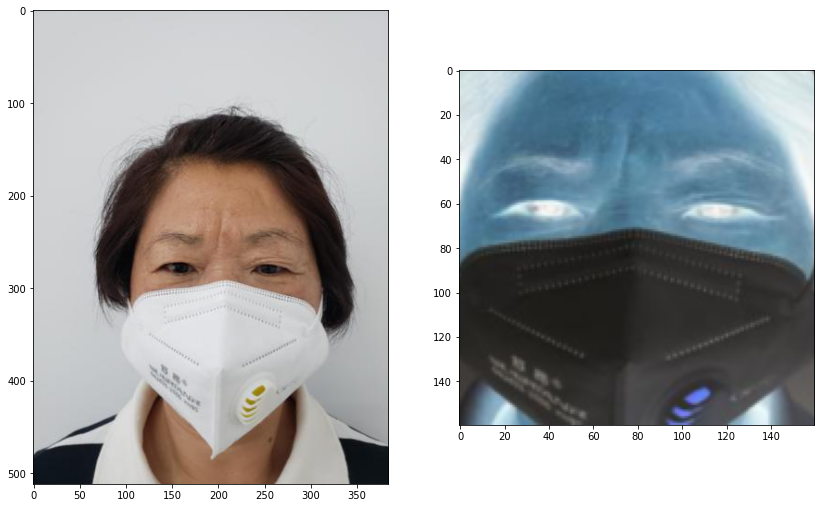

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
tf = transforms.ToPILImage()

one = tf(one)
axes[0].imshow(one)

one = detector(one)
axes[1].imshow(tf(one))

plt.show()

### 배치 단위로 확인

In [35]:
data2 = next(iter(train_dataloader))
x = data2[0][:16]
x_label = data2[1][:16]
print(x.shape)
print(x_label.shape)

torch.Size([16, 3, 512, 384])
torch.Size([16])


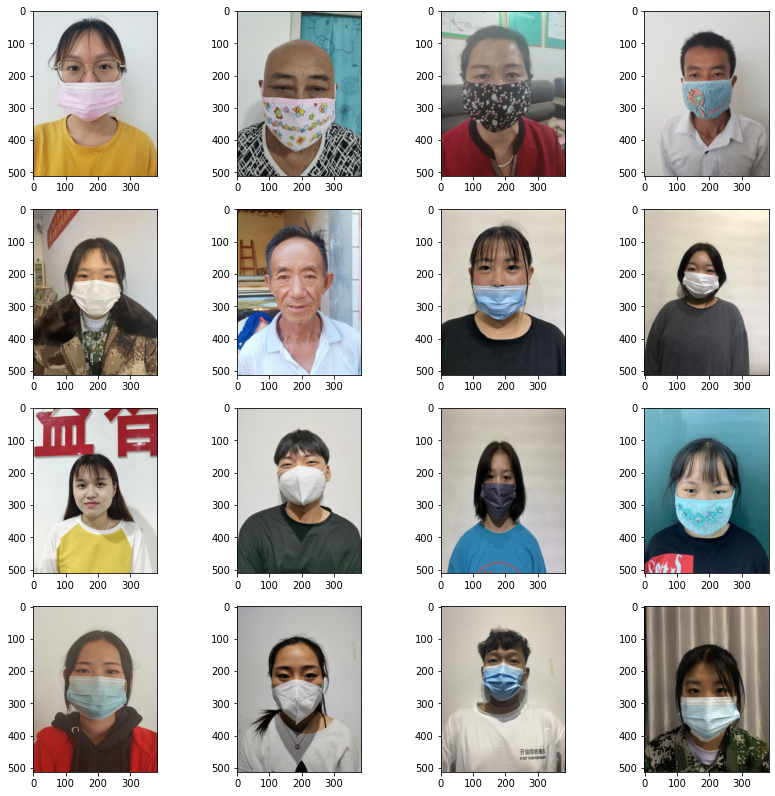

In [36]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
tf = transforms.ToPILImage()

for i in range(16):
    r,c = i//4, i%4
    axes[r][c].imshow(tf(x[i]))

plt.show()


tensor([[[222., 222., 222.,  ..., 223., 223., 223.],
         [222., 222., 222.,  ..., 223., 223., 223.],
         [222., 222., 222.,  ..., 223., 223., 223.],
         ...,
         [220., 220., 220.,  ..., 190., 191., 191.],
         [220., 220., 220.,  ..., 190., 191., 191.],
         [220., 220., 220.,  ..., 190., 191., 191.]],

        [[227., 227., 227.,  ..., 228., 228., 228.],
         [227., 227., 227.,  ..., 228., 228., 228.],
         [227., 227., 227.,  ..., 228., 228., 228.],
         ...,
         [221., 221., 221.,  ..., 190., 191., 191.],
         [221., 221., 221.,  ..., 190., 191., 191.],
         [221., 221., 221.,  ..., 190., 191., 191.]],

        [[230., 230., 230.,  ..., 231., 231., 231.],
         [230., 230., 230.,  ..., 231., 231., 231.],
         [230., 230., 230.,  ..., 231., 231., 231.],
         ...,
         [216., 216., 216.,  ..., 181., 183., 183.],
         [216., 216., 216.,  ..., 180., 182., 183.],
         [216., 216., 216.,  ..., 179., 181., 181.]]]

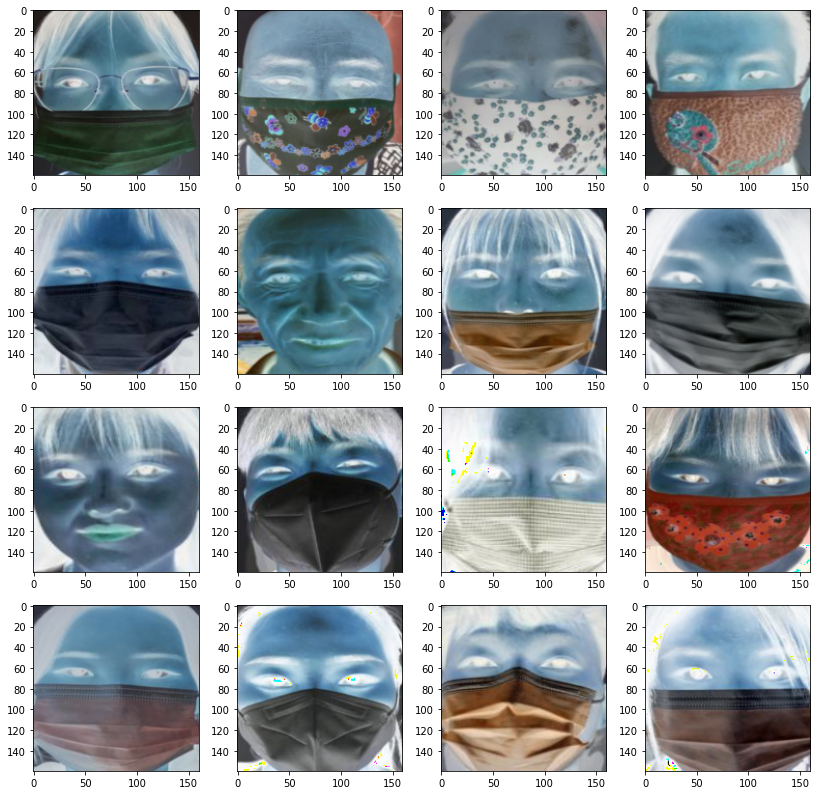

In [37]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
tf = transforms.ToPILImage()

for i in range(16):
    r,c = i//4, i%4
    image = tf(x[i])
    image = detector(image)
    print(image)
    axes[r][c].imshow(tf(image))

plt.show()

In [39]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
faces = []  #[tensor, tensor, ....]
for image, label in zip(x, x_label):
    face = detector(tf(image))
    faces.append(face)

faces = torch.stack(faces, dim=0)
print(faces.shape)
resnet.classify = True
image_embedding = resnet(faces)
#print(image_embedding.shape)
pred = image_embedding.argmax(dim=1)
pred

torch.Size([16, 3, 160, 160])


tensor([2804, 3293, 3883, 2804, 1378, 3883, 1378, 3293, 1378, 2804, 2804, 1378,
        2804, 3293, 3293, 2402])

In [19]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True
# print(one.shape)
# print(type(one))
# print(one.unsqueeze(0).shape)
img_prob = resnet(one.unsqueeze(0))
print(img_prob)  # shape: (1, 8631)
torch.max(img_prob, 1)

tensor([[-9.6931,  5.0185, -5.9108,  ..., -6.4448,  4.8799,  1.0357]],
       grad_fn=<AddmmBackward>)


torch.return_types.max(
values=tensor([26.8923], grad_fn=<MaxBackward0>),
indices=tensor([3293]))

In [25]:
help(resnet)

Help on InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1 object:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |  
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |  
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |  
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |          (default: {None})
 |      classify {bool} -- Whether the model should output classification probabilities or feature
 |          embeddings. (default: {False})
 |      num_classes {int} -- Number of output classes. If 'pretrained' is 

In [ ]:
ResNet18 = torchvision.models.resnet34(pretrained=True)

In [ ]:
ResNet18.fc = torch.nn.Linear(in_features=512, out_features=18, bias=True)

torch.nn.init.kaiming_normal_(ResNet18.fc.weight)
torch.nn.init.zeros_(ResNet18.fc.bias)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('My Device :', device)

My Device : cuda:0


In [ ]:
ResNet18.to(device)

LEARNING_RATE = 1e-4
NUM_EPOCH = 5

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18.parameters(), lr=LEARNING_RATE)

dataloaders = {
    "train" : train_dataloader,
    "valid" : valid_dataloader
}

In [44]:
resnet = InceptionResnetV1(pretrained='vggface2', num_classes=18)
#resnet.classify = True
resnet.to(device)

LEARNING_RATE = 1e-4
NUM_EPOCH = 5

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=LEARNING_RATE)

dataloaders = {
    "train" : train_dataloader,
    "valid" : valid_dataloader
}

In [45]:
best_acc = 0
best_loss = 0

for epoch in tqdm(range(NUM_EPOCH)):
    for phase in ['train', 'valid']:
        running_loss = 0
        running_acc = 0

        if phase == 'train':
            resnet.train()
        elif phase == 'valid':
            resnet.eval()

        for idx, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)

            faces = []
            for img in images:
                face = detector(tf(img))
                faces.append(face)
            faces = torch.stack(faces, dim=0)
            faces = faces.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                logits = resnet(faces)
                _, pred = torch.max(logits, 1)
                loss = loss_fn(logits, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(pred == labels.data)
            

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)


        print (f'[{phase}] 현재 EPOCH : {epoch}, loss : {epoch_loss}, acc : {epoch_acc}')

TypeError: expected Tensor as element 6 in argument 0, but got NoneType

In [ ]:
TEST_DIR = '/opt/ml/input/data/eval/'

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다
submission = pd.read_csv(os.path.join(TEST_DIR, 'info.csv'))
image_dir = os.path.join(TEST_DIR, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = maskDataset(image_paths, transform, train=False)
loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
ResNet18.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    images = images.to(device)
    with torch.no_grad():
        logits = ResNet18(images)
        _, pred = torch.max(logits, 1)
        # pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(TEST_DIR, 'submission.csv'), index=False)
print('test inference is done!')


test inference is done!


In [ ]:
sorted(submission['ans'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]